In [ ]:
%pip install geopandas pyproj

     |████████████████████████████████| 1.0MB 5.2MB/s 
     |████████████████████████████████| 6.6MB 15.4MB/s 
     |████████████████████████████████| 15.4MB 372kB/s 


## Import

In [ ]:
import ee
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
import datetime

from pyproj import Proj, transform

from calendar import monthrange

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=nbK77pggry1wijTKnohB0M9YtwHyBZplAEBPZfTbezk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7Gfp4j-_OpwjyKJQyz5xcqrb5qfbCAaWw4U5EV7LYMYgwKebGyKgU

Successfully saved authorization token.


In [ ]:
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load Switzerland map

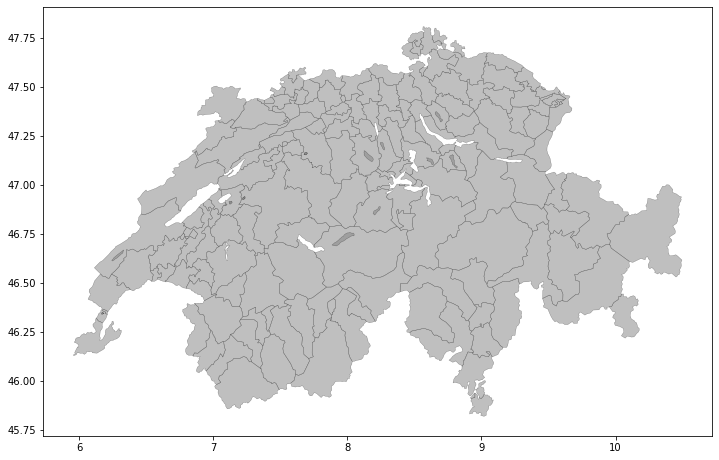

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

swiss = gpd.read_file(os.path.join("Data", "swiss_district.geojson"))
swiss.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

## Load France Map

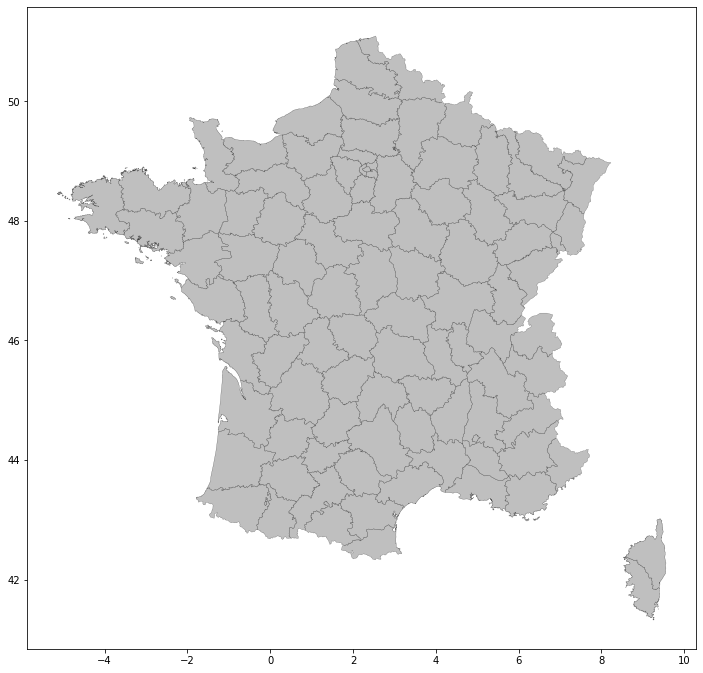

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

france = gpd.read_file(os.path.join("Data", "FRA_adm2.shp"))
france.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

# Load Italy Map

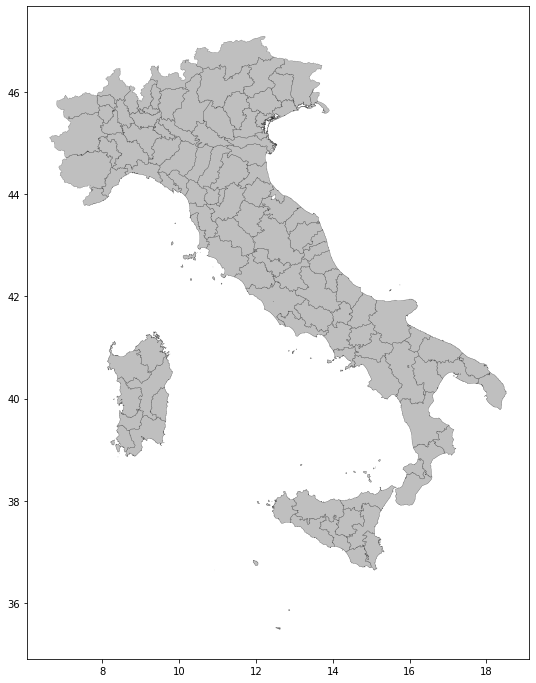

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

italy = gpd.read_file(os.path.join("Data","ITA_adm2.shp"))
italy.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

## Rename column

In [ ]:
swiss.rename(columns={'Secondary_':'districtName'}, inplace=True)
france.rename(columns={'NAME_2':'districtName'}, inplace=True)
italy.rename(columns={'NAME_2':'districtName'}, inplace=True)

## Get the mean value for a given region in Google Earth Engine

In [ ]:
VIIRSCollection = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad')
VIIRSParams = {'bands':['avg_rad']}
mean_values = {}

In [ ]:
for index, district_info in italy.iterrows():
  shapely_geometry = district_info.geometry
  if shapely_geometry.type == 'MultiPolygon':
    shapely_geometry = max(shapely_geometry, key=lambda a: a.area)


  geometry = ee.Geometry.Polygon(list(shapely_geometry.exterior.coords))
  district_name = str(district_info.districtName)

  mean_values[district_name] = []

  for year in range(2014,2021):
    for month in range(1,13):

      img = VIIRSCollection.filterDate(str(year) + '-' + str(month) + '-01', str(year) + '-' + str(month) + '-' + str(monthrange(year, month)[1])).median()

      mean_val = img.reduceRegion(
          geometry = geometry,
          reducer= ee.Reducer.mean(),
          scale= 500)
      mean_values[district_name].append(mean_val.getInfo()['avg_rad'])

  print(f"Ready for {district_name}")

Ready for Chieti
Ready for L'Aquila
Ready for Pescara
Ready for Teramo
Ready for Bari
Ready for Barletta-Andria-Trani
Ready for Brindisi
Ready for Foggia
Ready for Lecce
Ready for Taranto
Ready for Matera
Ready for Potenza
Ready for Catanzaro
Ready for Cosenza
Ready for Crotone
Ready for Reggio Di Calabria
Ready for Vibo Valentia
Ready for Avellino
Ready for Benevento
Ready for Caserta
Ready for Napoli
Ready for Salerno
Ready for Bologna
Ready for Ferrara
Ready for Forli' - Cesena
Ready for Modena
Ready for Parma
Ready for Piacenza
Ready for Ravenna
Ready for Reggio Nell'Emilia
Ready for Rimini
Ready for Gorizia
Ready for Pordenone
Ready for Trieste
Ready for Udine
Ready for Frosinone
Ready for Latina
Ready for Rieti
Ready for Roma
Ready for Viterbo
Ready for Genova
Ready for Imperia
Ready for La Spezia
Ready for Savona
Ready for Bergamo
Ready for Brescia
Ready for Como
Ready for Cremona
Ready for Lecco
Ready for Lodi
Ready for Mantua
Ready for Milano
Ready for Monza and Brianza
Ready 

## Compute datetime index

In [ ]:
def compute_months(first_date, second_date):
    year1, month1, year2, month2 = map(
        int, 
        (first_date[:4], first_date[5:7], second_date[:4], second_date[5:7])
    )

    return [
        '{:0>4}-{:0>2}'.format(year, month)
        for year in range(year1, year2 + 1)
        for month in range(month1 if year == year1 else 1, month2 + 1 if year == year2 else 13)
    ]
date_index = [datetime.date.fromisoformat(i + '-01') for i in compute_months("2014-01", "2020-12")]

## Save dataframe on the disk


In [ ]:
df_mean = pd.DataFrame().from_dict(mean_values)
df_mean['date'] = date_index
df_mean = df_mean.set_index(df_mean['date'], drop=True)
del df_mean['date']
df_mean = df_mean.T
df_mean.to_csv(os.path.join('Data','italy_district_light.csv'))

In [ ]:
class LightModel():
  def __init__(self):
    self.score_by_city = {}
    self.month_values_by_city = {}
    self.covid_years_by_city = {}

  def fit_predict(self, X):
    self.X = X
    i = 0
    for index, row in self.X .iterrows():
      no_covid_year = row.loc[datetime.date.fromisoformat('2014-01-01'):datetime.date.fromisoformat('2019-12-01')]
      df = pd.DataFrame(no_covid_year)
      df.columns = ['light']
      df['month'] = pd.DatetimeIndex(df.index).month

      covid_year = row.loc[datetime.date.fromisoformat('2020-01-01'):datetime.date.fromisoformat('2020-12-01')].to_list()

      city_score = 0
      month_values = {}
      for month in range(1,13):
        values = df[df['month'] == month]['light'].to_list()
        mean = np.mean(values)
        std = np.std(values)
        month_values[month] = (mean, std)
        if covid_year[month-1] > (mean + std) or covid_year[month-1] < (mean-std):
          city_score += 1

      self.month_values_by_city[index] = month_values
      self.score_by_city[index] = city_score
      self.covid_years_by_city[index] = covid_year

    return self.score_by_city

  def get_country_scores(self, mapping_dict):
    score_by_country = {}

    for city, value in self.score_by_city.items():
      country = mapping_dict[city]
      if country not in score_by_country:
        score_by_country[country] = list()
      score_by_country[country].append(value)

    for key, value in score_by_country.items():
      score_by_country[key] = np.mean(value)

    return score_by_country

  def display(self):
    size_plot = ceil(sqrt(len(self.X)))
    fig, axes = plt.subplots(ncols=size_plot, nrows=size_plot, figsize=(24,14))
    axes = axes.flatten()

    i=0
    for city, dict_month in self.month_values_by_city.items():

      mean, std = zip(*dict_month.values())
      mean = np.array(mean)
      std = np.array(std)

      axes[i].fill_between(range(1,13), mean - std, mean + std, alpha=0.5, label="2020")
      axes[i].plot(range(1,13), self.covid_years_by_city[city], c='r', label="2014-2019 range")
      axes[i].set_title(city)
      axes[i].set_xticks(range(1,13))
      if i == len(self.X) - 1:
        axes[i].legend()

      i+=1

    for index_ax in range(len(axes) - i):
      axes[len(axes) - index_ax - 1].axis('off')

    fig.tight_layout()


## Get prediction from light model

In [ ]:
lm = LightModel()
scores_by_district = lm.fit_predict(df_mean)
italy['ranking'] = scores_by_district.values()

## Plot switzerland district map with light ranking

Text(0.5, 1.0, 'Light variabilty')

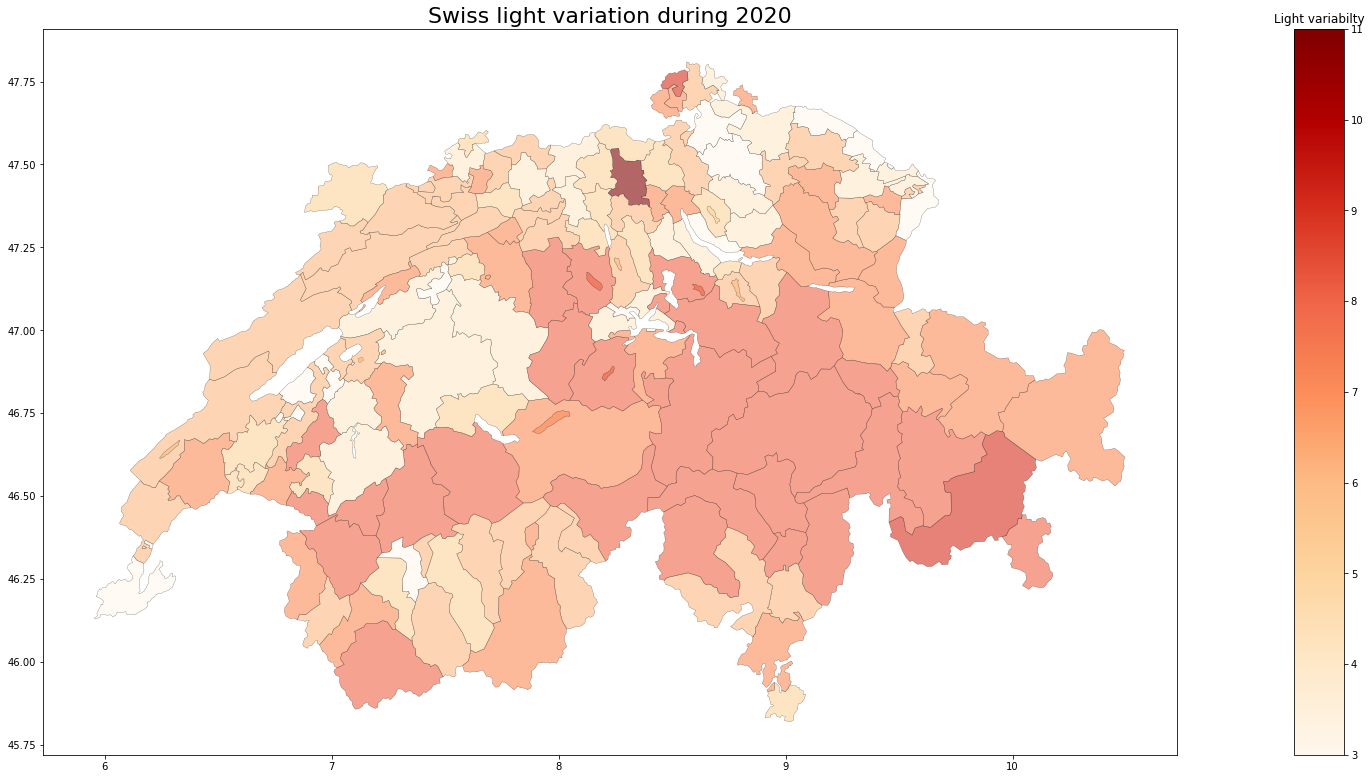

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(28,15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=-2)

swiss.plot(ax=ax, edgecolor='k',alpha=0.6,linewidth=0.3, column='ranking', cmap='OrRd',legend=True, cax=cax)
ax.set_title("Swiss light variation during 2020", fontsize=22)
cax.set_title("Light variabilty")

Text(0.5, 1.0, 'Light variabilty')

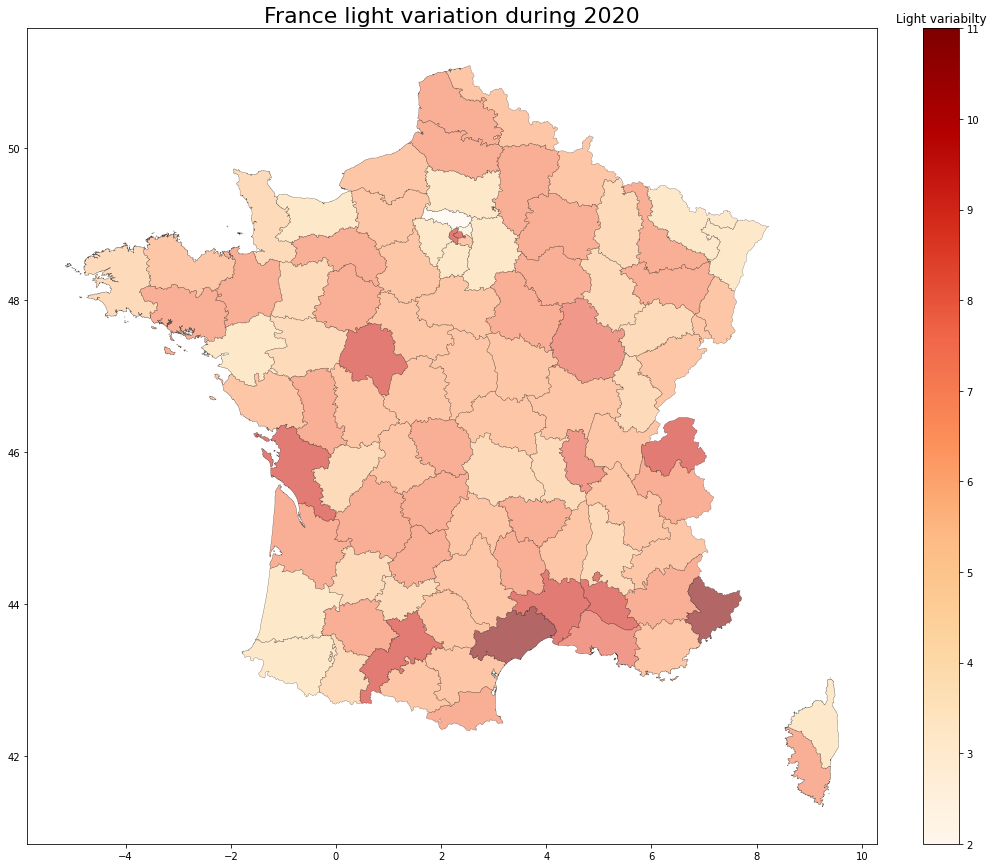

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(28,15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=-2)

france.plot(ax=ax, edgecolor='k',alpha=0.6,linewidth=0.3, column='ranking', cmap='OrRd',legend=True, cax=cax)
ax.set_title("France light variation during 2020", fontsize=22)
cax.set_title("Light variabilty")

Text(0.5, 1.0, 'Light variabilty')

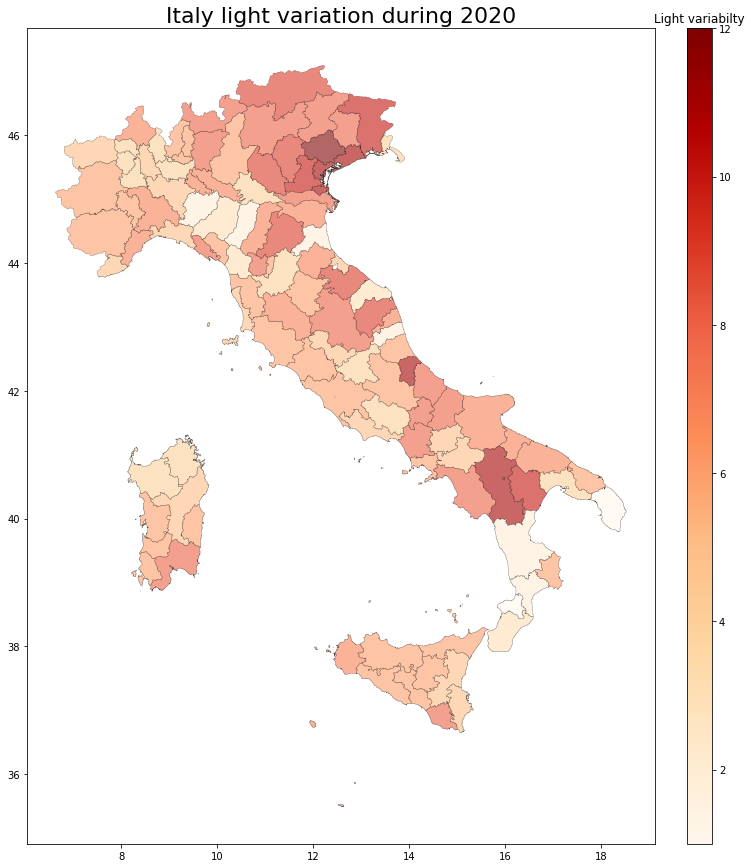

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(28,15))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=-1)

italy.plot(ax=ax, edgecolor='k',alpha=0.6,linewidth=0.3, column='ranking', cmap='OrRd',legend=True, cax=cax)
ax.set_title("Italy light variation during 2020", fontsize=22)
cax.set_title("Light variabilty")